# Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import f1_score

# Loading the File

In [3]:
trainingSet = pd.read_csv('./train.csv')
testingSet = pd.read_csv('./test.csv')

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

train.csv shape is  (370703, 24)
test.csv shape is  (92676, 23)

        id                         trans_num  trans_date trans_time  \
0   308467  26ad750c2ff71f32631b58913582d70a  2024-01-10   06:49:39   
1   261578  fea9c1efe3f2b97f27ad0ab5409ec861  2024-01-06   02:37:50   
2      341  2ae350b982be840f3666273e0c2f3a05  2024-01-18   21:40:21   
3  1147639  bbdd8adfc0a34ed0e817f809193c85c0  2024-01-21   16:20:15   
4   314152  fc7756004dc2a9bc450eb894a670b804  2024-01-21   19:36:26   

    unix_time        category     amt            cc_num    first     last  \
0  1704887379        misc_pos  188.38      676355457570   Andrea  Johnson   
1  1704526670     grocery_pos  102.63   377178373574671   Rhonda   Chavez   
2  1705632021   entertainment    1.62  3599292013370451  Stephen     Khan   
3  1705872015  health_fitness    5.64  3594292572430345   Justin   Reilly   
4  1705883786  health_fitness   97.09  4867547663675548    Alice   Duarte   

   ...    zip      lat      long city_pop    

# Adding Features

In [279]:
def add_features_to(df):
   label_encoder = LabelEncoder()
   df['category_encoded'] = label_encoder.fit_transform(df['category'])
   df['job_encoded']=label_encoder.fit_transform(df['job'])
   df['merchant_encoded']= label_encoder.fit_transform(df['merchant'])
   df['trans_num_encoded']= label_encoder.fit_transform(df['trans_num'])
   df['gender_encoded']= label_encoder.fit_transform(df['gender'])
   df['state_encoded']=label_encoder.fit_transform(df['state'])
   # Convert `dob` and `trans_date` to datetime
   df['dob'] = pd.to_datetime(df['dob'])
   df['trans_date'] = pd.to_datetime(df['trans_date'])
   # Calculate age
   df['age'] = df['trans_date'].dt.year - df['dob'].dt.year
   average_city_pop=df['city_pop'].mean()
   df['deviation_city_pop']=df['city_pop']-average_city_pop
   # Extract day, month, and hour from trans_date and trans_time
   df['trans_day'] = pd.to_datetime(df['trans_date']).dt.day
   df['trans_month'] = pd.to_datetime(df['trans_date']).dt.month
   df['trans_hour'] = pd.to_datetime(df['trans_time']).dt.hour
   # Flag unusual transaction times
   df['is_night'] = df['trans_hour'].apply(lambda x: 1 if x < 6 or x > 24 else 0)
   # Assuming `trans_date` is a column in your DataFrame in a string format (e.g., '2024-01-10')
    # Convert `trans_date` to a datetime object
   df['trans_date'] = pd.to_datetime(df['trans_date'])
    # Extract the day of the week (0 = Monday, 6 = Sunday)
   df['day_of_week'] = df['trans_date'].dt.dayofweek
    # Create `is_weekend` feature (1 for Saturday/Sunday, 0 otherwise)
   df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 6 else 0)
   threshold = df['amt'].quantile(0.96)
   # Create a column to flag big transactions
   df['is_big_transaction'] = df['amt'] > threshold

    # Count the number of big transactions per customer (cc_num)
   big_transaction_count = df.groupby('cc_num')['is_big_transaction'].sum()

    # Count the total number of transactions per customer
   total_transaction_count = df.groupby('cc_num')['cc_num'].count()

    # Calculate the frequency of big transactions per customer
   df['big_transaction_frequency'] = df['cc_num'].map(
        big_transaction_count / total_transaction_count
    )
   threshold = df['amt'].quantile(0.05)
   # Create a column to flag small transactions
   df['is_small_transaction'] = df['amt'] < threshold
    # Count the number of small transactions per customer
   small_transaction_count = df.groupby('cc_num')['is_small_transaction'].sum()

   # Calculate the frequency of small transactions per customer
   total_transaction_count = df.groupby('cc_num')['cc_num'].count()  # Already defined above
   df['small_transaction_frequency'] = df['cc_num'].map(
   small_transaction_count / total_transaction_count
) 
   df['is_urban']=df['city_pop']>50000
   category_variation = df.groupby('cc_num')['category'].nunique().reset_index()
   category_variation = category_variation.rename(columns={'category':'category_variation'})
   df = df.merge(category_variation,on='cc_num',how='left')
   return df

# Process the DataFrame
train = add_features_to(trainingSet)
X_submission = add_features_to(testingSet)
# The training set is where the score is not null
X_train =  train[train['is_fraud'].notnull()]

/var/folders/td/3s3bcbys3qs05zfg3_jzxfhc0000gn/T/ipykernel_3543/1561578115.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['trans_hour'] = pd.to_datetime(df['trans_time']).dt.hour
/var/folders/td/3s3bcbys3qs05zfg3_jzxfhc0000gn/T/ipykernel_3543/1561578115.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['trans_hour'] = pd.to_datetime(df['trans_time']).dt.hour


# Sample + Split into Training & Testing Set 

In [264]:
# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['is_fraud']),
    X_train['is_fraud'],
    test_size=1/4.0,
    random_state=0
)

# Features Selection

In [271]:
features = ['amt','category_encoded','unix_time','age','gender_encoded','city_pop','deviation_city_pop',
            'is_night','is_weekend', 'big_transaction_frequency','small_transaction_frequency',
            'trans_day','trans_hour','is_urban']
X_train_select = X_train[features]
X_test_select = X_test[features]
X_submission_select = X_submission[features]

# Model Creation

In [273]:
from sklearn.ensemble import HistGradientBoostingClassifier 
best_hg_model = HistGradientBoostingClassifier(
    max_iter=2000,
    learning_rate=0.05,
    max_leaf_nodes=120,
    min_samples_leaf=40,
    random_state=42
)
# Fitting the model

best_hg_model.fit(X_train_select, Y_train)

# Making predictions
best_hg_preds = best_hg_model.predict(X_test_select)
print("f1_score:",f1_score(Y_test,best_hg_preds))

f1_score: 0.9785521518867478


# Confusion Matrix

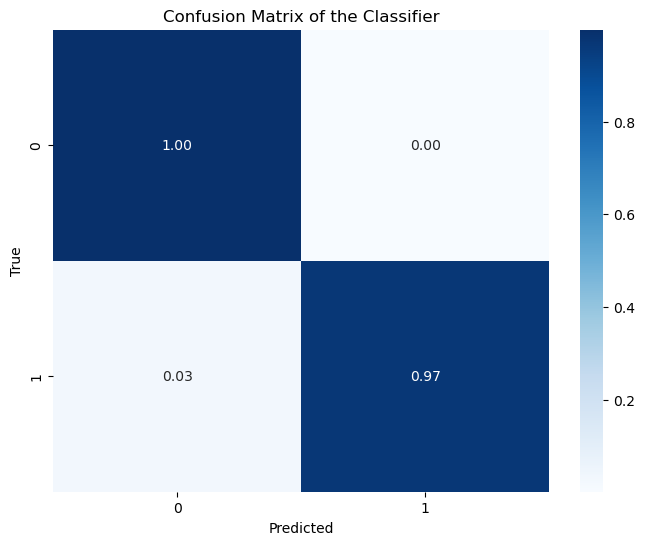

In [275]:
# Confusion Matrix
cm = confusion_matrix(Y_test, best_hg_preds, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt=".2f")
plt.title('Confusion Matrix of the Classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Saving The File

In [277]:
# Create the submission file
X_submission['is_fraud'] = best_hg_model.predict(X_submission_select)
submission = X_submission[['id', 'is_fraud']]
print(submission.shape)
submission.to_csv("./submission.csv", index=False)

(92676, 2)
